In [11]:
import numpy as np

In [12]:
from utils.utils import load_graph_json

In [13]:
nodes, edges, street_graph = load_graph_json("knowledge_base/graph_data.json")

In [14]:
comuna = 10

In [15]:
from shapely.geometry import Point
import itertools


node_id_counter = itertools.count(max(nodes.keys()) + 1 if nodes else 1)
edge_id_counter = itertools.count(max(edges.keys()) + 1 if edges else 1)


def find_closest_edge(bin_coord, edges, max_distance=float('inf')):
    """
    Find the edge closest to the bin coordinate.

    Args:
        bin_coord (tuple): (lon, lat) of the bin
        edges (dict): edge_id -> edge attributes (including geometry)
        max_distance (float): maximum allowed distance to snap

    Returns:
        edge_id (int) of the closest edge, or None if too far
    """
    bin_point = Point(bin_coord)
    closest_edge_id = None
    min_dist = float('inf')

    for edge_id, data in edges.items():
        edge_geom = data["geometry"]
        dist = edge_geom.distance(bin_point)
        if dist < min_dist:
            min_dist = dist
            closest_edge_id = edge_id

    if min_dist > max_distance:
        return None
    return closest_edge_id


def insert_bin_into_edge(bin_coord, edge_id, nodes, edges, street_graph, priority=1):
    """
    Insert a bin node in the middle of the given edge with a priority.
    Updates nodes, edges, and street_graph.

    Args:
        bin_coord (tuple): (lon, lat) of the bin
        edge_id (int): edge where the bin sits
        nodes (dict): node_id -> node attributes
        edges (dict): edge_id -> edge attributes
        street_graph (dict): adjacency list node_id -> [(neighbor_id, edge_id), ...]
        priority (int/float): bin priority (higher = more important)
    
    Returns:
        bin_id (int): ID of the new bin node
    """
    bin_id = next(node_id_counter)
    nodes[bin_id] = {"coord": bin_coord, "type": "bin", "priority": priority}

    # Get original edge info
    old_edge = edges[edge_id]
    u, v = old_edge["u"], old_edge["v"]

    # Remove original edge from adjacency list
    if (v, edge_id) in street_graph.get(u, []):
        street_graph[u].remove((v, edge_id))
    if (u, edge_id) in street_graph.get(v, []):
        street_graph[v].remove((u, edge_id))

    # Create two new edges: u -> bin, bin -> v
    edge1_id = next(edge_id_counter)
    edge2_id = next(edge_id_counter)

    edge1 = old_edge.copy()
    edge1.update({"u": u, "v": bin_id})
    edges[edge1_id] = edge1

    edge2 = old_edge.copy()
    edge2.update({"u": bin_id, "v": v})
    edges[edge2_id] = edge2

    # Update adjacency list respecting original direction
    direction = old_edge.get("direction", "doble").lower()
    if direction == "creciente":
        street_graph.setdefault(u, []).append((bin_id, edge1_id))
        street_graph.setdefault(bin_id, []).append((v, edge2_id))
    elif direction == "decreciente":
        street_graph.setdefault(bin_id, []).append((u, edge1_id))
        street_graph.setdefault(v, []).append((bin_id, edge2_id))
    else:  # two-way
        street_graph.setdefault(u, []).append((bin_id, edge1_id))
        street_graph.setdefault(bin_id, []).append((u, edge1_id))
        street_graph.setdefault(bin_id, []).append((v, edge2_id))
        street_graph.setdefault(v, []).append((bin_id, edge2_id))

    return bin_id


def add_bin(bin_coord, nodes, edges, street_graph, max_distance=20, priority=1):
    """
    Add a bin to the graph with a priority.

    Args:
        bin_coord (tuple): (lon, lat)
        nodes, edges, street_graph: existing graph structures
        max_distance (float): max distance to snap to edge
        priority (int/float): higher means higher priority

    Returns:
        bin_id (int) or None if no edge found within max_distance
    """
    edge_id = find_closest_edge(bin_coord, edges, max_distance)
    if edge_id is None:
        print("No edge close enough to place the bin.")
        return None
    bin_id = insert_bin_into_edge(bin_coord, edge_id, nodes, edges, street_graph, priority=priority)
    return bin_id


In [16]:
import random
from shapely.geometry import LineString, Point

def generate_random_bin_coords(neighborhood, edges, num_bins=1):
    """
    Generate random bin coordinates along edges of a given neighborhood.

    Args:
        neighborhood (int): neighborhood ID to filter edges
        edges (dict): edge_id -> edge attributes (including 'geometry' and 'neighborhood')
        num_bins (int): number of bin coordinates to generate

    Returns:
        List of (lon, lat) tuples for bins
    """
    # Filter edges in the neighborhood
    neighborhood_edges = [
        data["geometry"] for data in edges.values()
        if not np.isnan(data.get("neighborhood", np.nan)) and int(data["neighborhood"]) == neighborhood
    ]
    
    if not neighborhood_edges:
        raise ValueError(f"No edges found in neighborhood {neighborhood}")

    bin_coords = []
    for _ in range(num_bins):
        # Pick a random edge
        edge_geom = random.choice(neighborhood_edges)
        # Pick the midpoint
        midpoint = edge_geom.interpolate(0.5, normalized=True)
        bin_coords.append((midpoint.x, midpoint.y))
    
    return bin_coords

In [17]:
import random

bin_coords_list = generate_random_bin_coords(comuna, edges, num_bins=50)

for bin_coord in bin_coords_list:
    # Assign a random priority between 1 and 10
    priority = random.randint(1, 10)
    
    bin_id = add_bin(bin_coord, nodes, edges, street_graph, max_distance=100, priority=priority)
    print(f"Added bin {bin_id} at {bin_coord} with priority {priority}")

Added bin 17718 at (-58.499023883523655, -34.62215615467637) with priority 7
Added bin 17719 at (-58.50299703749738, -34.63154992306829) with priority 2
Added bin 17720 at (-58.52791745536334, -34.61976998200778) with priority 7
Added bin 17721 at (-58.518490371734, -34.620325568514716) with priority 10
Added bin 17722 at (-58.48857093969283, -34.635385338113366) with priority 6
Added bin 17723 at (-58.52092672949038, -34.62059162767498) with priority 7
Added bin 17724 at (-58.49864762349703, -34.641738506087854) with priority 9
Added bin 17725 at (-58.49535898937616, -34.62076972625978) with priority 5
Added bin 17726 at (-58.49404082417189, -34.62055034345612) with priority 10
Added bin 17727 at (-58.49072653844615, -34.63139933014004) with priority 5
Added bin 17728 at (-58.505199058964244, -34.61246208424225) with priority 10
Added bin 17729 at (-58.52143767410544, -34.619047588384696) with priority 10
Added bin 17730 at (-58.4978843204821, -34.632567793474564) with priority 1
Adde

In [18]:
import heapq
import itertools


def dijkstra_directed(graph, edges, start):
    """
    Compute shortest paths from start node to all others in the graph.
    Returns distances and previous-node mapping.
    """
    dist = {start: 0}
    prev = {start: None}
    pq = [(0, start)]
    
    while pq:
        d_curr, u = heapq.heappop(pq)
        if d_curr > dist[u]:
            continue
        for v, edge_id in graph.get(u, []):
            weight = edges[edge_id].get("distance", 1)
            alt = d_curr + weight
            if v not in dist or alt < dist[v]:
                dist[v] = alt
                prev[v] = u
                heapq.heappush(pq, (alt, v))
    return dist, prev


def reconstruct_path(prev, u, v):
    path = []
    current = v
    while current is not None:
        path.append(current)
        current = prev.get(current)
    path = path[::-1]
    if path[0] != u:
        return []  # No path
    return path


def two_opt(route, distance_matrix):
    """
    Apply 2-opt to improve route distance.
    route: list of node IDs
    distance_matrix: precomputed dictionary
    """
    best = route[:]
    improved = True
    while improved:
        improved = False
        n = len(best)
        for i in range(1, n-2):
            for j in range(i+1, n-1):
                if j - i == 1: continue  # skip adjacent
                a, b = best[i-1], best[i]
                c, d = best[j], best[j+1]
                old = distance_matrix[a][b] + distance_matrix[c][d]
                new = distance_matrix[a][c] + distance_matrix[b][d]
                if new < old:
                    best[i:j+1] = reversed(best[i:j+1])
                    improved = True
        route = best
    return best

def priority_greedy_mTSP_balanced(nodes, street_graph, edges, num_trucks, depot_id, balance_factor=1.0):
    """
    Assign bins to multiple trucks using priority-weighted greedy + 2-opt,
    while trying to balance the number of bins per truck.
    
    balance_factor > 0 increases weight of load balancing; 0 ignores it.
    """
    
    bins = [nid for nid, data in nodes.items() if data['type']=='bin']
    
    if not bins:
        return [[] for _ in range(num_trucks)]
    
    
    bins_sorted = sorted(bins, key=lambda nid: nodes[nid].get('priority',1), reverse=True)
    
    
    nodes_of_interest = [depot_id] + bins_sorted
    distance_matrix = {}
    path_matrix = {}
    for u in nodes_of_interest:
        dist, prev = dijkstra_directed(street_graph, edges, u)
        distance_matrix[u] = {v: dist[v] for v in nodes_of_interest if v != u and v in dist}
        path_matrix[u] = prev
    
    
    routes = [[depot_id] for _ in range(num_trucks)]
    
 
    for bin_id in bins_sorted:
        best_truck = None
        best_score = float('inf')
        for t_idx in range(num_trucks):
            last_node = routes[t_idx][-1]
            if bin_id not in distance_matrix[last_node]:
                continue
            dist_cost = distance_matrix[last_node][bin_id]
            load_penalty = balance_factor * (len(routes[t_idx]) - 1)  
            score = dist_cost + load_penalty
            if score < best_score:
                best_score = score
                best_truck = t_idx
        if best_truck is None:
            raise ValueError(f"No path found from any truck to bin {bin_id}")
        routes[best_truck].append(bin_id)
    
    
    for t_idx in range(num_trucks):
        routes[t_idx].append(depot_id)
    
    
    for t_idx in range(num_trucks):
        route = routes[t_idx]
        if len(route) > 3:  # at least depot + 2 nodes
            routes[t_idx] = two_opt(route, distance_matrix)
    
    return routes, distance_matrix, path_matrix




In [19]:
import random


target_neighborhood = comuna

edges_in_neigh = [edge_id for edge_id, data in edges.items()
                  if not np.isnan(data['neighborhood']) and int(data['neighborhood']) == target_neighborhood]

intersection_ids = set()
for edge_id in edges_in_neigh:
    u, v = edges[edge_id]['u'], edges[edge_id]['v']
    if nodes[u]['type'] == 'intersection':
        intersection_ids.add(u)
    if nodes[v]['type'] == 'intersection':
        intersection_ids.add(v)

if not intersection_ids:
    raise ValueError(f"No intersections found in neighborhood {target_neighborhood}")
depot_id = random.choice(list(intersection_ids))

print(f"Selected depot node ID: {depot_id}, coordinates: {nodes[depot_id]['coord']}")


Selected depot node ID: 9194, coordinates: [-58.5151792, -34.6247891]


In [20]:
num_trucks = 5
routes, distance_matrix, path_matrix = priority_greedy_mTSP_balanced(
    nodes, street_graph, edges, num_trucks, depot_id, balance_factor=2.0
)

for t_idx, route in enumerate(routes):
    print(f"Truck {t_idx+1} route: {route}")

Truck 1 route: [9194, 17721, 17728, 17760, 17752, 17736, 17763, 17733, 17722, 17759, 17727, 17758, 17753, 17730, 9194]
Truck 2 route: [9194, 17732, 17726, 17754, 17731, 17739, 17756, 17761, 17767, 17766, 17747, 17724, 17742, 9194]
Truck 3 route: [9194, 17762, 17723, 17738, 17746, 17720, 17729, 17750, 9194]
Truck 4 route: [9194, 17719, 17749, 17744, 17757, 17740, 17725, 17718, 17748, 17755, 17743, 17734, 17751, 17741, 17735, 9194]
Truck 5 route: [9194, 17764, 17737, 17765, 17745, 9194]


In [21]:
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors
import random
import heapq
import numpy as np

def get_route_path(u, v, street_graph, edges, nodes):
    """
    Returns a list of coordinates along the shortest path from u to v.
    Uses Dijkstra to get the path in node IDs.
    """
    prev = {u: None}
    dist = {u: 0}
    pq = [(0, u)]
    
    while pq:
        d_curr, node = heapq.heappop(pq)
        if node == v:
            break
        for neighbor, edge_id in street_graph.get(node, []):
            edge_distance = edges[edge_id].get("distance", 1)
            alt = d_curr + edge_distance
            if neighbor not in dist or alt < dist[neighbor]:
                dist[neighbor] = alt
                prev[neighbor] = node
                heapq.heappush(pq, (alt, neighbor))
    
    # Reconstruct path
    path = []
    current = v
    while current is not None:
        path.append(current)
        current = prev.get(current)
    path = path[::-1]
    
    coords = [nodes[n]['coord'] for n in path]
    return coords

def generate_random_colors(n):
    """
    Generate n distinct bright colors, random each run.
    """
    colors = []
    for _ in range(n):
        h = random.random()
        s = 0.8 + 0.2 * random.random()
        v = 0.8 + 0.2 * random.random()
        rgb = mcolors.hsv_to_rgb((h, s, v))
        colors.append(mcolors.to_hex(rgb))
    return colors

def plot_neighborhood_routes(nodes, edges, street_graph, routes, depot_id, target_neighborhood):
    """
    Plots streets, bins, depot, and truck routes for a specific neighborhood.
    Shows the visit order of each bin (per truck) as a number.
    """
    # Colors and sizes
    street_color = '#1f77b4'
    bin_color = '#ff7f0e'
    bin_marker_size = 200
    depot_color = '#2ca02c'
    depot_marker_size = 200
    route_linewidth = 4
    
    # Generate truck colors dynamically
    truck_colors = generate_random_colors(len(routes))
    
    edges_to_plot = set()
    for u_id, neighbors in street_graph.items():
        for v_id, edge_id in neighbors:
            neigh = edges[edge_id].get('neighborhood')
            if not np.isnan(neigh) and int(neigh) == target_neighborhood:
                edges_to_plot.add((u_id, v_id))
    
    # Separate street nodes and bin nodes
    street_nodes = set()
    bin_nodes = set()
    for u_id, v_id in edges_to_plot:
        for node_id in (u_id, v_id):
            if nodes[node_id]['type'] == 'bin':
                bin_nodes.add(node_id)
            else:
                street_nodes.add(node_id)
    
    fig, ax = plt.subplots(figsize=(12,12))
    
    # Plot streets
    for u_id, v_id in edges_to_plot:
        u_coord = nodes[u_id]['coord']
        v_coord = nodes[v_id]['coord']
        ax.plot([u_coord[0], v_coord[0]], [u_coord[1], v_coord[1]],
                color=street_color, alpha=0.7, linewidth=1)
    
    # Plot street nodes
    if street_nodes:
        x_street, y_street = zip(*[nodes[n]['coord'] for n in street_nodes])
        ax.scatter(x_street, y_street, s=20, color=street_color)
    
    # Plot bins
    if bin_nodes:
        x_bins, y_bins = zip(*[nodes[n]['coord'] for n in bin_nodes])
        ax.scatter(x_bins, y_bins, s=bin_marker_size, color=bin_color,
                   marker='o', edgecolors='black', zorder=5)
    
    # Annotate bins with visit order per truck
    for t_idx, route in enumerate(routes):
        visit_num = 1
        for node_id in route:
            if node_id == depot_id:
                continue  # skip depot
            if nodes[node_id]['type'] == 'bin':
                x, y = nodes[node_id]['coord']
                ax.text(x, y, str(visit_num),
                        fontsize=12, fontweight="bold",
                        color=truck_colors[t_idx],  # match truck color
                        ha="center", va="center", zorder=7)
                visit_num += 1
    
    # Plot depot
    depot_coord = nodes[depot_id]['coord']
    ax.scatter(depot_coord[0], depot_coord[1], s=depot_marker_size,
               color=depot_color, marker='o', edgecolors='black', zorder=6)
    
    # Plot truck routes along streets
    for t_idx, route in enumerate(routes):
        color = truck_colors[t_idx % len(truck_colors)]
        for i in range(len(route)-1):
            u, v = route[i], route[i+1]
            path_coords = get_route_path(u, v, street_graph, edges, nodes)
            xs, ys = zip(*path_coords)
            ax.plot(xs, ys, color=color, linewidth=route_linewidth,
                    alpha=0.9, zorder=4)
    
    # Add basemap
    ctx.add_basemap(ax, crs="EPSG:4326")
    ax.set_axis_off()
    plt.show()



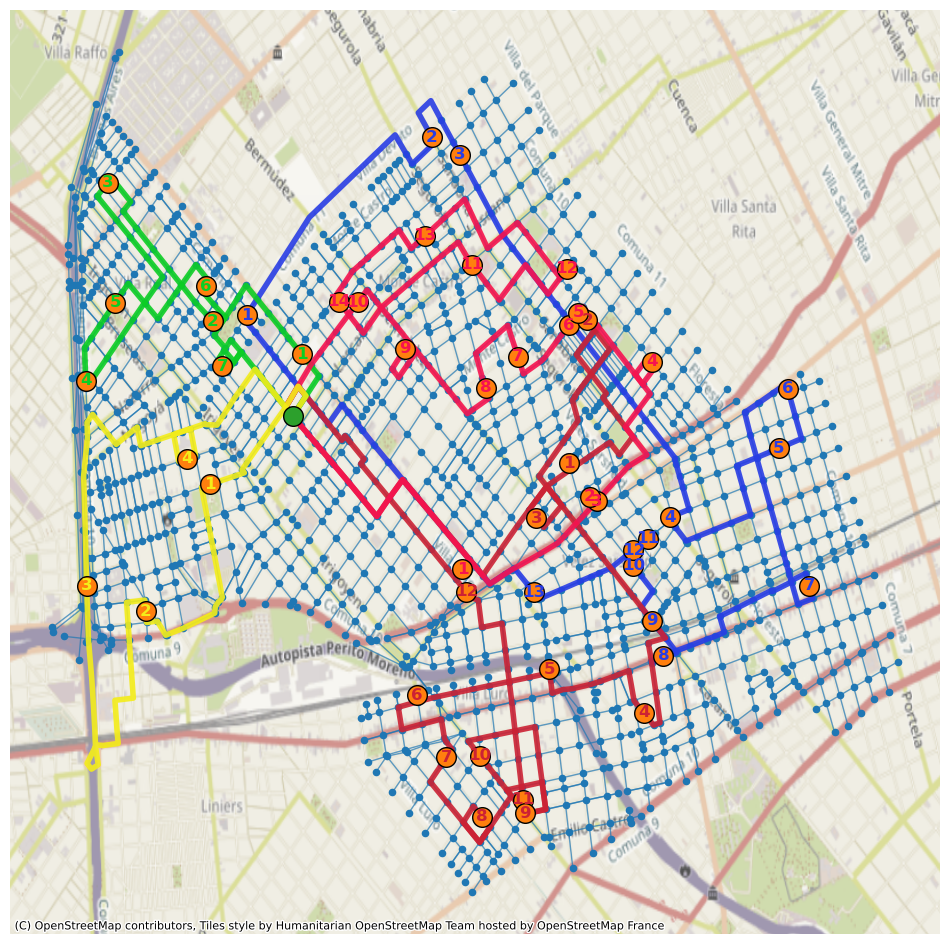

In [22]:
plot_neighborhood_routes(nodes, edges, street_graph, routes, depot_id, target_neighborhood=comuna)